<h1>Capstone Project - Modelling

<img src="https://library.sportingnews.com/styles/twitter_card_120x120/s3/2022-03/cn.jpg?itok=4UFpH4_I" width="500">

###
The project aims to find solutions to the following problems:
<li>Let's say player X departs a team, and the team needs a player who is similar to the player who is departing.</li>
<li>Clubs occasionally fail to sign their top transfer targets for a variety of reasons. Then they would have to choose the best alternate signing.</li>
<li>Coaches occasionally have to select a versatile player to replace one who is currently playing in a different position owing to an injury or another circumstance. </li>


### Import Libraries

In [81]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import pickle

from sklearn_som.som import SOM


### Functions

In [82]:
def plot_correlation(corr,figsize=(6,6)):

    """
    Plot correlation matrix
    i/p: corr
    """

    plt.figure(figsize = figsize) # setting the size of the output

    sns.heatmap(corr,
                annot = True,
                linecolor='black',
                center=0,
                vmin=-1,
                vmax=1,
                cmap = sns.diverging_palette(600,600, as_cmap=True),
                fmt='.4g')

    plt.title('Car features and thier correlation') # naming the plot

    #plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

    plt.show()

### Load Data

In [83]:
player_df = pd.read_csv('data/player_abilities.csv', low_memory=False)
player_df.head()

Unnamed: 0  sofifa_id         short_name preferred_foot  overall  \
0           0     158023           L. Messi           Left       93   
1           1     188545     R. Lewandowski          Right       92   
2           2      20801  Cristiano Ronaldo          Right       91   
3           3     190871          Neymar Jr          Right       91   
4           4     192985       K. De Bruyne          Right       91   

  player_positions  weak_foot  skill_moves    work_rate body_type  ...  \
0       RW, ST, CF          4            4   Medium/Low    Unique  ...   
1               ST          4            4  High/Medium    Unique  ...   
2           ST, LW          4            5     High/Low    Unique  ...   
3          LW, CAM          5            5  High/Medium    Unique  ...   
4          CM, CAM          5            4    High/High    Unique  ...   

   mentality_composure  defending_marking_awareness  \
0                   96                           20   
1                   88                           35   
2                   95                           24   
3                   93                           35   
4                   89                           68   

   defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                         35                        24                   6   
1                         42                        19                  15   
2                         32                        24                   7   
3                         32                        29                   9   
4                         65                        53                  15   

   goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
0                    11                   15                       14   
1                     6                   12                        8   
2                    11                   15                       14   
3                     9                   15                       15   
4                    13                    5                       10   

   goalkeeping_reflexes  goalkeeping_speed  
0                     8                NaN  
1                    10                NaN  
2                    11                NaN  
3                    11                NaN  
4                    13                NaN  

[5 rows x 51 columns]

In [84]:
player_df.shape

(19239, 51)

> ### There are 19239 male players in the dataset

Drop Unnamed column  

In [85]:
player_df.drop(columns=['Unnamed: 0'],inplace=True)
player_df.set_index('sofifa_id',inplace=True)
player_df.head()

short_name preferred_foot  overall player_positions  \
sofifa_id                                                               
158023              L. Messi           Left       93       RW, ST, CF   
188545        R. Lewandowski          Right       92               ST   
20801      Cristiano Ronaldo          Right       91           ST, LW   
190871             Neymar Jr          Right       91          LW, CAM   
192985          K. De Bruyne          Right       91          CM, CAM   

           weak_foot  skill_moves    work_rate body_type  pace  shooting  ...  \
sofifa_id                                                                 ...   
158023             4            4   Medium/Low    Unique  85.0      92.0  ...   
188545             4            4  High/Medium    Unique  78.0      92.0  ...   
20801              4            5     High/Low    Unique  87.0      94.0  ...   
190871             5            5  High/Medium    Unique  91.0      83.0  ...   
192985             5            4    High/High    Unique  76.0      86.0  ...   

           mentality_composure  defending_marking_awareness  \
sofifa_id                                                     
158023                      96                           20   
188545                      88                           35   
20801                       95                           24   
190871                      93                           35   
192985                      89                           68   

           defending_standing_tackle  defending_sliding_tackle  \
sofifa_id                                                        
158023                            35                        24   
188545                            42                        19   
20801                             32                        24   
190871                            32                        29   
192985                            65                        53   

           goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  \
sofifa_id                                                                  
158023                      6                    11                   15   
188545                     15                     6                   12   
20801                       7                    11                   15   
190871                      9                     9                   15   
192985                     15                    13                    5   

           goalkeeping_positioning  goalkeeping_reflexes  goalkeeping_speed  
sofifa_id                                                                    
158023                          14                     8                NaN  
188545                           8                    10                NaN  
20801                           14                    11                NaN  
190871                          15                    11                NaN  
192985                          10                    13                NaN  

[5 rows x 49 columns]

In [86]:
# saves the player names for future use
player_names = player_df['short_name']

In [87]:
player_df['goalkeeping_speed'].fillna(0,inplace=True)
player_df.head()

short_name preferred_foot  overall player_positions  \
sofifa_id                                                               
158023              L. Messi           Left       93       RW, ST, CF   
188545        R. Lewandowski          Right       92               ST   
20801      Cristiano Ronaldo          Right       91           ST, LW   
190871             Neymar Jr          Right       91          LW, CAM   
192985          K. De Bruyne          Right       91          CM, CAM   

           weak_foot  skill_moves    work_rate body_type  pace  shooting  ...  \
sofifa_id                                                                 ...   
158023             4            4   Medium/Low    Unique  85.0      92.0  ...   
188545             4            4  High/Medium    Unique  78.0      92.0  ...   
20801              4            5     High/Low    Unique  87.0      94.0  ...   
190871             5            5  High/Medium    Unique  91.0      83.0  ...   
192985             5            4    High/High    Unique  76.0      86.0  ...   

           mentality_composure  defending_marking_awareness  \
sofifa_id                                                     
158023                      96                           20   
188545                      88                           35   
20801                       95                           24   
190871                      93                           35   
192985                      89                           68   

           defending_standing_tackle  defending_sliding_tackle  \
sofifa_id                                                        
158023                            35                        24   
188545                            42                        19   
20801                             32                        24   
190871                            32                        29   
192985                            65                        53   

           goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  \
sofifa_id                                                                  
158023                      6                    11                   15   
188545                     15                     6                   12   
20801                       7                    11                   15   
190871                      9                     9                   15   
192985                     15                    13                    5   

           goalkeeping_positioning  goalkeeping_reflexes  goalkeeping_speed  
sofifa_id                                                                    
158023                          14                     8                0.0  
188545                           8                    10                0.0  
20801                           14                    11                0.0  
190871                          15                    11                0.0  
192985                          10                    13                0.0  

[5 rows x 49 columns]

In [88]:
player_df.dtypes

short_name                      object
preferred_foot                  object
overall                          int64
player_positions                object
weak_foot                        int64
skill_moves                      int64
work_rate                       object
body_type                       object
pace                           float64
shooting                       float64
passing                        float64
dribbling                      float64
defending                      float64
physic                         float64
attacking_crossing               int64
attacking_finishing              int64
attacking_heading_accuracy       int64
attacking_short_passing          int64
attacking_volleys                int64
skill_dribbling                  int64
skill_curve                      int64
skill_fk_accuracy                int64
skill_long_passing               int64
skill_ball_control               int64
movement_acceleration            int64
movement_sprint_speed    

## Feature Engineering

In [89]:
def feature_eng(df):

    """
    Performs Feature engineering
    i/p: corr
    """
    df['goalkeeping_speed'].fillna(0,inplace=True)

    # creates a new column for main position
    df["first_position"] = df.apply (lambda x: x["player_positions"].split (",")[0], axis=1)
    # creates a new column for total positions
    df["total_position_count"] = df.apply (lambda x: len (x["player_positions"].split (",")), axis=1)

    # creates a new column for 1st workrate
    df["work_rate1"] = df["work_rate"].apply (lambda x: x.split ("/")[0])
    # creates a new column for 2nd workrate
    df["work_rate2"] = df["work_rate"].apply (lambda x: x.split ("/")[1])


    # list of columns to label encode
    label_encode_cols = ['preferred_foot', 'work_rate1', 'work_rate2', 'first_position','body_type']
    labelencoder = LabelEncoder()

    # label encoding categrical column values
    for col in label_encode_cols:
        
        df[col + '_Encoded'] = labelencoder.fit_transform(df[col])

    df.drop(columns=['player_positions','work_rate'],inplace=True)
    
    return df

player_df_new = feature_eng(player_df.copy())

In [90]:
player_positions = player_df_new['first_position']

player_df_new.head()

short_name preferred_foot  overall  weak_foot  skill_moves  \
sofifa_id                                                                      
158023              L. Messi           Left       93          4            4   
188545        R. Lewandowski          Right       92          4            4   
20801      Cristiano Ronaldo          Right       91          4            5   
190871             Neymar Jr          Right       91          5            5   
192985          K. De Bruyne          Right       91          5            4   

          body_type  pace  shooting  passing  dribbling  ...  \
sofifa_id                                                ...   
158023       Unique  85.0      92.0     91.0       95.0  ...   
188545       Unique  78.0      92.0     79.0       86.0  ...   
20801        Unique  87.0      94.0     80.0       88.0  ...   
190871       Unique  91.0      83.0     86.0       94.0  ...   
192985       Unique  76.0      86.0     93.0       88.0  ...   

           goalkeeping_speed  first_position  total_position_count  \
sofifa_id                                                            
158023                   0.0              RW                     3   
188545                   0.0              ST                     1   
20801                    0.0              ST                     2   
190871                   0.0              LW                     2   
192985                   0.0              CM                     2   

           work_rate1  work_rate2  preferred_foot_Encoded  work_rate1_Encoded  \
sofifa_id                                                                       
158023         Medium         Low                       0                   2   
188545           High      Medium                       1                   0   
20801            High         Low                       1                   0   
190871           High      Medium                       1                   0   
192985           High        High                       1                   0   

           work_rate2_Encoded  first_position_Encoded  body_type_Encoded  
sofifa_id                                                                 
158023                      1                      12                  9  
188545                      2                      14                  9  
20801                       1                      14                  9  
190871                      2                       8                  9  
192985                      0                       4                  9  

[5 rows x 56 columns]

Object type columns

In [91]:
object_clmns = player_df_new.dtypes[player_df_new.dtypes == "object"].index 
object_clmns


Index(['short_name', 'preferred_foot', 'body_type', 'first_position',
       'work_rate1', 'work_rate2'],
      dtype='object')

Numeric columns

In [92]:
numeric_clmns = player_df_new.dtypes[player_df_new.dtypes != "object"].index 
numeric_clmns


Index(['overall', 'weak_foot', 'skill_moves', 'pace', 'shooting', 'passing',
       'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',

### Creating a new dataset based on numerical features 

In [93]:
player_df_new = player_df_new[numeric_clmns]
player_df_new.head()

overall  weak_foot  skill_moves  pace  shooting  passing  \
sofifa_id                                                             
158023          93          4            4  85.0      92.0     91.0   
188545          92          4            4  78.0      92.0     79.0   
20801           91          4            5  87.0      94.0     80.0   
190871          91          5            5  91.0      83.0     86.0   
192985          91          5            4  76.0      86.0     93.0   

           dribbling  defending  physic  attacking_crossing  ...  \
sofifa_id                                                    ...   
158023          95.0       34.0    65.0                  85  ...   
188545          86.0       44.0    82.0                  71  ...   
20801           88.0       34.0    75.0                  87  ...   
190871          94.0       37.0    63.0                  85  ...   
192985          88.0       64.0    78.0                  94  ...   

           goalkeeping_kicking  goalkeeping_positioning  goalkeeping_reflexes  \
sofifa_id                                                                       
158023                      15                       14                     8   
188545                      12                        8                    10   
20801                       15                       14                    11   
190871                      15                       15                    11   
192985                       5                       10                    13   

           goalkeeping_speed  total_position_count  preferred_foot_Encoded  \
sofifa_id                                                                    
158023                   0.0                     3                       0   
188545                   0.0                     1                       1   
20801                    0.0                     2                       1   
190871                   0.0                     2                       1   
192985                   0.0                     2                       1   

           work_rate1_Encoded  work_rate2_Encoded  first_position_Encoded  \
sofifa_id                                                                   
158023                      2                   1                      12   
188545                      0                   2                      14   
20801                       0                   1                      14   
190871                      0                   2                       8   
192985                      0                   0                       4   

           body_type_Encoded  
sofifa_id                     
158023                     9  
188545                     9  
20801                      9  
190871                     9  
192985                     9  

[5 rows x 50 columns]

### Plot Correlation 

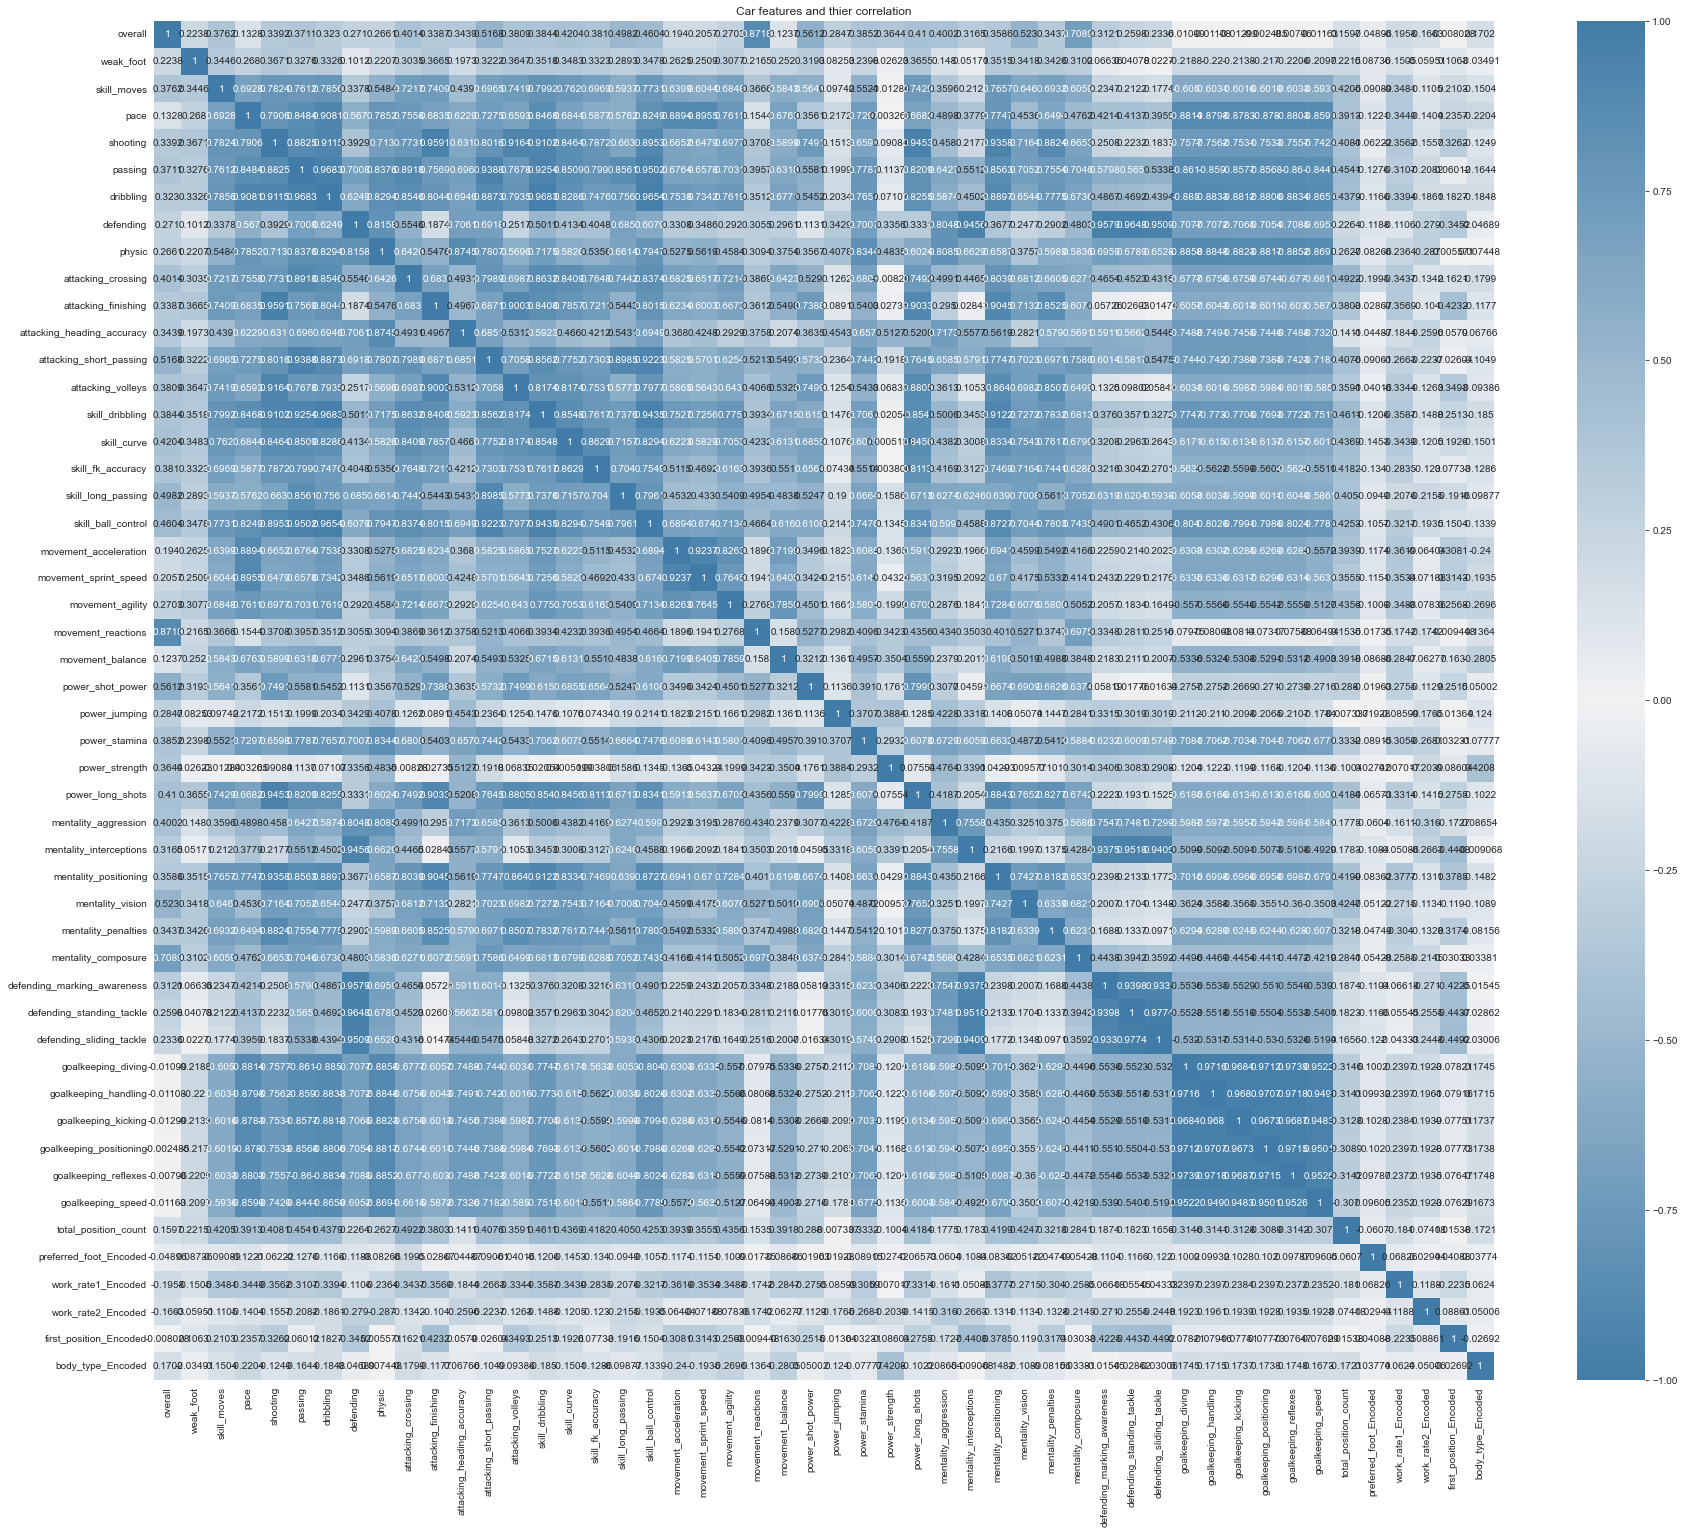

In [94]:
plot_correlation(player_df_new.corr(),figsize=(30,25))

> ## From the correlation matrix,it can be observed that there is high correlation between some  of the features

In [95]:
fig = px.imshow(player_df_new.corr(), text_auto=True)
fig.show()

In [96]:
player_df_new.shape

(19239, 50)

## Modelling

In [97]:
pl_df = player_df_new.drop(columns=['goalkeeping_speed'])

pl_df.head()

overall  weak_foot  skill_moves  pace  shooting  passing  \
sofifa_id                                                             
158023          93          4            4  85.0      92.0     91.0   
188545          92          4            4  78.0      92.0     79.0   
20801           91          4            5  87.0      94.0     80.0   
190871          91          5            5  91.0      83.0     86.0   
192985          91          5            4  76.0      86.0     93.0   

           dribbling  defending  physic  attacking_crossing  ...  \
sofifa_id                                                    ...   
158023          95.0       34.0    65.0                  85  ...   
188545          86.0       44.0    82.0                  71  ...   
20801           88.0       34.0    75.0                  87  ...   
190871          94.0       37.0    63.0                  85  ...   
192985          88.0       64.0    78.0                  94  ...   

           goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
sofifa_id                                                                       
158023                       11                   15                       14   
188545                        6                   12                        8   
20801                        11                   15                       14   
190871                        9                   15                       15   
192985                       13                    5                       10   

           goalkeeping_reflexes  total_position_count  preferred_foot_Encoded  \
sofifa_id                                                                       
158023                        8                     3                       0   
188545                       10                     1                       1   
20801                        11                     2                       1   
190871                       11                     2                       1   
192985                       13                     2                       1   

           work_rate1_Encoded  work_rate2_Encoded  first_position_Encoded  \
sofifa_id                                                                   
158023                      2                   1                      12   
188545                      0                   2                      14   
20801                       0                   1                      14   
190871                      0                   2                       8   
192985                      0                   0                       4   

           body_type_Encoded  
sofifa_id                     
158023                     9  
188545                     9  
20801                      9  
190871                     9  
192985                     9  

[5 rows x 49 columns]

In [98]:

if 'pred_labels' in pl_df:
    pl_df = player_df.drop(columns=['pred_labels'])

if 'name' in pl_df:
    pl_df = player_df.drop(columns=['name'])



Creating a KMeans model using k value of 20

This is done because we have observed that there can be upto 27 different positions on a football pitch

In [99]:
km = KMeans(n_clusters=20, random_state=124)
km.fit(pl_df)

pred_labels = km.labels_ 


### Clusters and their corresponding points

In [100]:
pl_df["pred_labels"] = pred_labels
pl_df["name"] = player_names

# get indices of each cluster and their points
cluster_dict = {i: pl_df.index[pl_df['pred_labels']==i].tolist() for i in range(km.n_clusters)}

pl_df.to_csv('models/male_pl_df.csv')
pl_df.head()

overall  weak_foot  skill_moves  pace  shooting  passing  \
sofifa_id                                                             
158023          93          4            4  85.0      92.0     91.0   
188545          92          4            4  78.0      92.0     79.0   
20801           91          4            5  87.0      94.0     80.0   
190871          91          5            5  91.0      83.0     86.0   
192985          91          5            4  76.0      86.0     93.0   

           dribbling  defending  physic  attacking_crossing  ...  \
sofifa_id                                                    ...   
158023          95.0       34.0    65.0                  85  ...   
188545          86.0       44.0    82.0                  71  ...   
20801           88.0       34.0    75.0                  87  ...   
190871          94.0       37.0    63.0                  85  ...   
192985          88.0       64.0    78.0                  94  ...   

           goalkeeping_positioning  goalkeeping_reflexes  \
sofifa_id                                                  
158023                          14                     8   
188545                           8                    10   
20801                           14                    11   
190871                          15                    11   
192985                          10                    13   

           total_position_count  preferred_foot_Encoded  work_rate1_Encoded  \
sofifa_id                                                                     
158023                        3                       0                   2   
188545                        1                       1                   0   
20801                         2                       1                   0   
190871                        2                       1                   0   
192985                        2                       1                   0   

           work_rate2_Encoded  first_position_Encoded  body_type_Encoded  \
sofifa_id                                                                  
158023                      1                      12                  9   
188545                      2                      14                  9   
20801                       1                      14                  9   
190871                      2                       8                  9   
192985                      0                       4                  9   

           pred_labels               name  
sofifa_id                                  
158023               5           L. Messi  
188545               5     R. Lewandowski  
20801                5  Cristiano Ronaldo  
190871               5          Neymar Jr  
192985              12       K. De Bruyne  

[5 rows x 51 columns]

### obtain player id 

In [101]:
pldf = pd.read_csv('models/male_pl_df.csv')
playerA_id = pldf[pldf['name']=="L. Messi"]['sofifa_id'].item()
playerA_id

158023

In [102]:
playerA_id = pldf[(pldf['name']=="Cristiano Ronaldo") & (pldf['overall']==91)]['sofifa_id'].item()
playerA_id

20801

###  Scatter Plot of the player clusters

In [103]:
fig = px.scatter_3d(pl_df, x='passing', y='overall', z='dribbling',
              color="pred_labels", log_x=True, hover_name="name", hover_data=["overall"])
fig.show()

We can see that players have been clustered based on their similarity
<li>Eg. Messi and Neymar are close to each other and are part of the same cluster 
<li> These clusters are almost analogous to their original player positions
Eg. Midfielders like Verratti and Thiago are in the same cluster  

## PCA


In [104]:
if 'pred_labels' in pl_df.columns:
    pl_df = pl_df.drop(columns=['pred_labels'])


if 'name' in pl_df.columns:
    pl_df = pl_df.drop(columns=['name'])

# try: 
X_std=pd.DataFrame(StandardScaler().fit_transform(pl_df),index=pl_df.index,columns=pl_df.columns)
X_std

overall  weak_foot  skill_moves      pace  shooting   passing  \
sofifa_id                                                                   
158023     3.957501   1.569295     2.146241  1.024453  2.153464  1.968245   
188545     3.812154   1.569295     2.146241  0.729901  2.153464  1.378341   
20801      3.666806   1.569295     3.448937  1.108610  2.248215  1.427500   
190871     3.666806   3.058403     3.448937  1.276925  1.727087  1.722452   
192985     3.666806   3.058403     2.146241  0.645744  1.869213  2.066563   
...             ...        ...          ...       ...       ...       ...   
261962    -2.728494   0.080187    -0.459150 -0.111674 -0.546927 -0.243895   
262040    -2.728494   0.080187    -0.459150 -0.069595 -0.357426 -0.047260   
262760    -2.728494   0.080187    -0.459150 -0.027517 -0.452177 -0.293054   
262820    -2.728494   0.080187    -0.459150  0.309114 -0.025799 -0.735482   
264540    -2.728494   0.080187    -0.459150  0.309114 -0.404802 -0.293054   

           dribbling  defending    physic  attacking_crossing  ...  \
sofifa_id                                                      ...   
158023      1.819019  -0.537399  0.329387            1.964190  ...   
188545      1.403208  -0.088594  1.090178            1.187887  ...   
20801       1.495610  -0.537399  0.776911            2.075090  ...   
190871      1.772817  -0.402757  0.239882            1.964190  ...   
192985      1.495610   0.809014  0.911169            2.463242  ...   
...              ...        ...       ...                 ...  ...   
261962     -0.352440  -0.178355 -0.386652           -0.198369  ...   
262040     -0.444842  -0.223236 -0.297147            0.245233  ...   
262760     -0.306238  -0.223236 -0.252394           -0.586520  ...   
262820     -0.352440  -1.390127 -0.699919           -1.141023  ...   
264540     -0.352440  -0.447638 -0.431404           -0.586520  ...   

           goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
sofifa_id                                                                       
158023                -0.308358            -0.063713                -0.130678   
188545                -0.605286            -0.244828                -0.482391   
20801                 -0.308358            -0.063713                -0.130678   
190871                -0.427130            -0.063713                -0.072059   
192985                -0.189587            -0.667428                -0.365153   
...                         ...                  ...                      ...   
261962                -0.367744            -0.667428                -0.072059   
262040                -0.248973            -0.607056                -0.482391   
262760                -0.605286            -0.546685                -0.365153   
262820                -0.367744            -0.546685                -0.130678   
264540                -0.189587            -0.184456                -0.423772   

           goalkeeping_reflexes  total_position_count  preferred_foot_Encoded  \
sofifa_id                                                                       
158023                -0.474818              1.848041               -1.792891   
188545                -0.362988             -0.911113                0.557758   
20801                 -0.307073              0.468464                0.557758   
190871                -0.307073              0.468464                0.557758   
192985                -0.195244              0.468464                0.557758   
...                         ...                   ...                     ...   
261962                -0.195244             -0.911113                0.557758   
262040                -0.362988             -0.911113                0.557758   
262760                -0.586647             -0.911113                0.557758   
262820                -0.083414             -0.911113                0.557758   
264540                -0.139329             -0.911113                0.55

In [105]:
pca = PCA()
principalcomponents = pca.fit_transform(X_std)

### Bar plot of variance ratio of each PC's

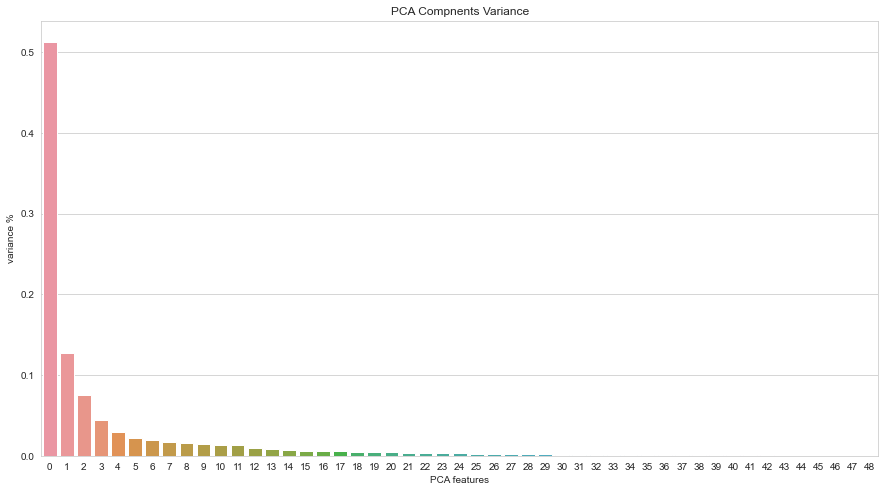

In [106]:
features = list(range(pca.n_components_))

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.barplot(x=features, y=pca.explained_variance_ratio_, capsize=.2)
plt.title('PCA Compnents Variance')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

> ### The first 4 components are having the highest variance ratio and hence they will be chosen for modelling

In [107]:
PCA_components = pd.DataFrame(principalcomponents)
PCA_components['sofifa_id'] = pl_df.index
PCA_components.set_index('sofifa_id',inplace=True)
PCA_components.head()

0         1         2         3         4         5   \
sofifa_id                                                               
158023    -9.487960 -5.452532  5.605597 -0.578360 -0.329905  1.428386   
188545    -8.670262 -3.597223  6.061310  3.102560 -1.206948  0.406549   
20801     -9.140817 -4.881812  5.968269  2.624330 -2.037404 -0.073866   
190871    -9.184619 -5.316562  4.807843 -0.624266 -1.061897 -0.546476   
192985    -9.800229 -1.644998  6.452011 -0.738035  0.193892 -1.106858   

                 6         7         8         9   ...        39        40  \
sofifa_id                                          ...                       
158023    -0.742513  1.428529 -2.693534 -1.005845  ... -0.325066 -0.111435   
188545    -1.270633  0.400448  0.756518 -0.083557  ...  0.243177  0.245544   
20801     -0.308260  0.761441 -0.456701 -0.526441  ... -0.247752 -0.043024   
190871    -1.175882  2.130537  0.468819 -0.398815  ... -0.243029  0.131464   
192985     1.069755  2.051114  0.020209 -0.356290  ...  0.226373 -0.050032   

                 41        42        43        44        45        46  \
sofifa_id                                                               
158023     0.038218 -0.205580 -0.025516 -0.014056 -0.026737  0.002726   
188545    -0.223713 -0.530317 -0.136538 -0.068578 -0.020361 -0.015618   
20801      0.134999 -0.178060 -0.044909 -0.073495  0.015230 -0.034582   
190871     0.072694  0.029777  0.030064 -0.045587 -0.040979 -0.013681   
192985    -0.072142 -0.184091 -0.044561  0.000417 -0.006970  0.004367   

                 47        48  
sofifa_id                      
158023    -0.012602 -0.025656  
188545     0.004184 -0.000148  
20801      0.013471 -0.016187  
190871    -0.008443 -0.007009  
192985    -0.001382  0.001856  

[5 rows x 49 columns]

In [108]:
model = KMeans(n_clusters=25)

# Fit model to samples
model.fit(PCA_components.iloc[:,:4]) ## Using 4 feature components




KMeans(n_clusters=25)

In [109]:
PCA_components["pred_labels"] = pred_labels
PCA_components["name"] = player_names

# create a dictionary of clusters and their indices
cluster_dict = {i: pl_df.index[PCA_components['pred_labels']==i].tolist() for i in range(model.n_clusters)}


abilities=['dribbling','passing','overall','defending','physic','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy',
            'skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina','power_strength',
            'power_long_shots','mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision','mentality_penalties','mentality_composure','defending_marking_awareness','defending_standing_tackle',
            'defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes']

for col in abilities:
    PCA_components[col] = pl_df[col]

PCA_components.head()

0         1         2         3         4         5  \
sofifa_id                                                               
158023    -9.487960 -5.452532  5.605597 -0.578360 -0.329905  1.428386   
188545    -8.670262 -3.597223  6.061310  3.102560 -1.206948  0.406549   
20801     -9.140817 -4.881812  5.968269  2.624330 -2.037404 -0.073866   
190871    -9.184619 -5.316562  4.807843 -0.624266 -1.061897 -0.546476   
192985    -9.800229 -1.644998  6.452011 -0.738035  0.193892 -1.106858   

                  6         7         8         9  ...  mentality_penalties  \
sofifa_id                                          ...                        
158023    -0.742513  1.428529 -2.693534 -1.005845  ...                   75   
188545    -1.270633  0.400448  0.756518 -0.083557  ...                   90   
20801     -0.308260  0.761441 -0.456701 -0.526441  ...                   88   
190871    -1.175882  2.130537  0.468819 -0.398815  ...                   93   
192985     1.069755  2.051114  0.020209 -0.356290  ...                   83   

           mentality_composure  defending_marking_awareness  \
sofifa_id                                                     
158023                      96                           20   
188545                      88                           35   
20801                       95                           24   
190871                      93                           35   
192985                      89                           68   

           defending_standing_tackle  defending_sliding_tackle  \
sofifa_id                                                        
158023                            35                        24   
188545                            42                        19   
20801                             32                        24   
190871                            32                        29   
192985                            65                        53   

           goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  \
sofifa_id                                                                  
158023                      6                    11                   15   
188545                     15                     6                   12   
20801                       7                    11                   15   
190871                      9                     9                   15   
192985                     15                    13                    5   

           goalkeeping_positioning  goalkeeping_reflexes  
sofifa_id                                                 
158023                          14                     8  
188545                           8                    10  
20801                           14                    11  
190871                          15                    11  
192985                          10                    13  

[5 rows x 90 columns]

### Best ball carrier

In [110]:
fig = px.scatter_3d(PCA_components, x='passing', y='overall', z='dribbling',
              color="pred_labels", log_x=True, hover_name="name", hover_data=["overall"])
fig.show()


> ### We can see that the best ball carriers are Messi and Neymar

### Finding Keepers

In [111]:
fig = px.scatter_3d(PCA_components, x='goalkeeping_diving', y='goalkeeping_reflexes', z='goalkeeping_positioning',
              color="pred_labels", log_x=True, hover_name="name", hover_data=["passing"])
fig.show()

> ### From this we can see that KMeans(with PCA) produced great results

## DBSCAN

In [112]:
scaler = MinMaxScaler()

DBScan_df = pl_df[['goalkeeping_diving',
                   'goalkeeping_reflexes',
                   'goalkeeping_positioning',
                   'passing',
                   'pace']]

db = DBSCAN(eps=0.3, min_samples=7, n_jobs=-1).fit(DBScan_df) ## We played around with tweaking the epsilon value and minimum sample size.

# add the cluster labels to the columns
DBScan_df['pred_labels'] = db.labels_
DBScan_df['name'] = player_names


# Count the total number of clusters
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
n_clusters

20

In [113]:
fig = px.scatter_3d(DBScan_df, x='goalkeeping_diving', y='passing', z='goalkeeping_positioning',
              color="pred_labels", log_x=True, hover_name="name", hover_data=["pace"])

fig.show()

> ## DBSCAN could not produce great results with the data. 

Function to find top 5 similiar players

In [114]:
# saving prediction results to csv
PCA_components.to_csv('models/male_pca_result.csv')

In [115]:
def get_similiar_players(playerA_id,player_count=5):
    """
    find top 5 similiar players
    i/p: player_id
    """

    # find the cluster the player belongs to

 
    # find the cluster the player belongs
    cluster = PCA_components.loc[playerA_id]['pred_labels']

    # get the features of playerA
    playerA_data = PCA_components.loc[playerA_id].head()

    # get the other players in the same cluster
    cluster_indices = cluster_dict[cluster]


    # get the other players in the same cluster
    cluster_indices = cluster_dict[cluster]

    # initialise a temp dictionary to store player ids and distances
    dist_dict={}

    # iterate through each player in the cluster
    for player_id in cluster_indices:

        if(player_id != playerA_id):

        
            playerB_data = PCA_components.loc[player_id].head()
            dist = np.linalg.norm(playerA_data-playerB_data)
            dist_dict[player_id]=dist.round(4)
        
    # create a new dataframe to show the id and distance
    dist_df = pd.DataFrame(columns=['id','distance'])

    # add data to the dataframe
    dist_df['id'] = dist_dict.keys()
    dist_df['distance'] = dist_dict.values()
    dist_df.sort_values('distance',inplace=True)

    # shortlist players based on player count
    similiar_players = dist_df.head(player_count)
    
    name_list=[]

    for id in list(similiar_players['id']):
        name_list.append(player_df.loc[id]['short_name'])

    similiar_players['name'] =name_list

    return similiar_players

    


Players similiar to Messi

In [116]:
similiar_players = get_similiar_players(playerA_id=158023,player_count=10)
similiar_players

id  distance          name
2   190871    1.1335     Neymar Jr
6   200104    2.0188        H. Son
14  211110    2.7796     P. Dybala
28  202556    2.7888      M. Depay
12  183898    2.8107   Á. Di María
41  216594    2.9252      N. Fekir
27  194765    3.0024  A. Griezmann
8   209331    3.0037      M. Salah
29  206113    3.0427     S. Gnabry
5   165153    3.1323    K. Benzema

## Heirarchical Clustering

In [117]:
if 'pred_labels' in pl_df.columns:
    pl_df = pl_df.drop(columns=['pred_labels'])


if 'name' in pl_df.columns:
    pl_df = pl_df.drop(columns=['name'])

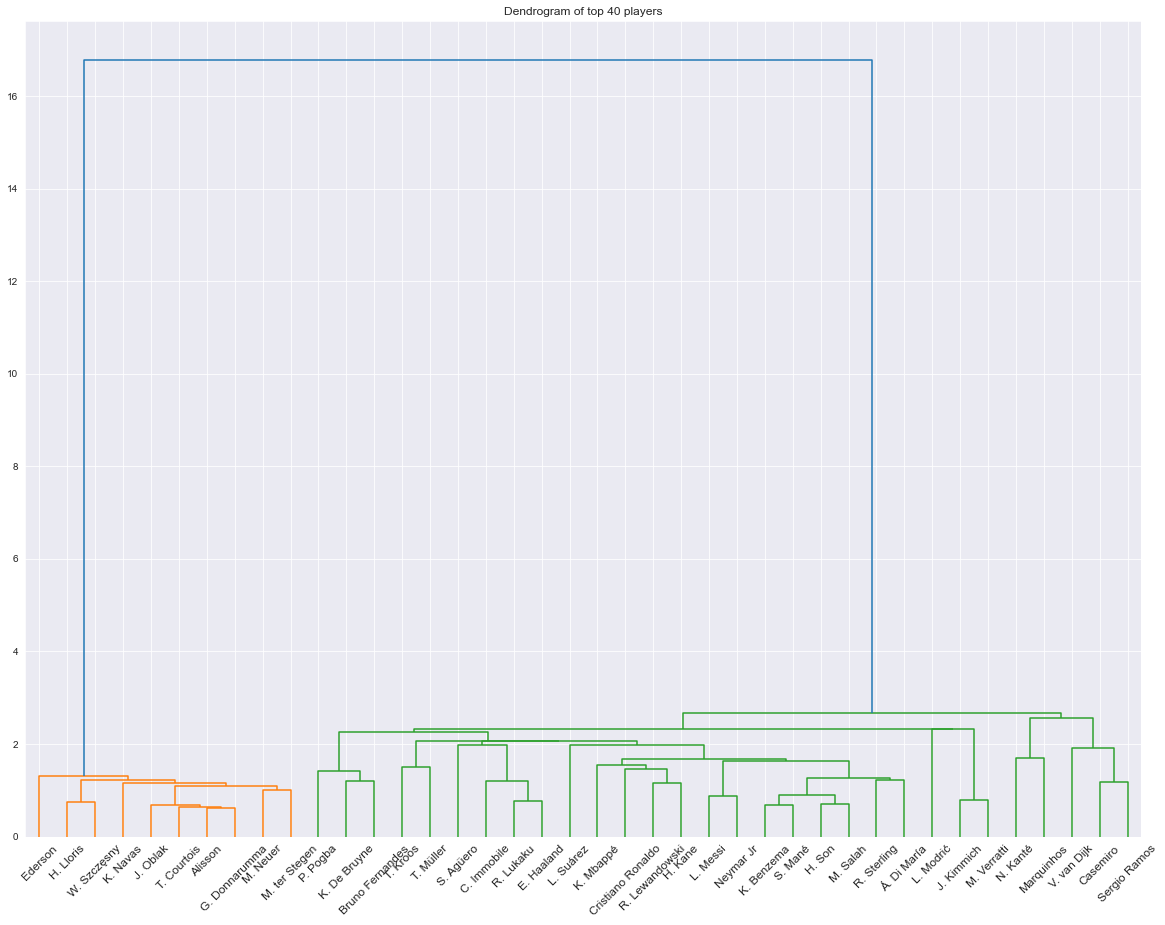

In [118]:
import scipy.cluster.hierarchy as shc


sns.set_style('darkgrid')

plt.figure(figsize=(20, 15))  
plt.title("Dendrogram of top 40 players")  


# create a dendrogram of top 40 players in the dataset
dend = shc.dendrogram(shc.linkage(PCA_components.iloc[:40,:4].values,method='single'),
                                    labels=list(player_names[:40]),
                                    leaf_rotation=45,
                                    leaf_font_size=12)


> ## using Heirachical Clustering, a dendrogram was generated for top 40 players